# Tutorial: Setting up a Jansen-Rit network model using YAML templates

This tutorial shows you how to set up a network model according to Jansen & Rit (Biol. Cybern., 1995). The following questions will be answered in the respective order:
1. What is a YAML template file?
2. How do I create a network model from my template?
3. How do I run simulations on my network model?

## Part 1: What is a YAML template file?

[YAML](https://yaml.org/spec/1.2/spec.html) is a data formatting specification that aims to be human-readable and machine-readable at the same time. It's current installment can be thought of as an extension to the also popular JSON standard. 

PyRates uses YAML files to provide a simple and readable way to define network models without any Python code. Below you see a YAML template that defines the potential-to-rate operator (PRO) in a neural population. It defines an operator with the equation
$$m_{out} = \frac{m_{max}}{1. + \exp{(r \cdot (V_{thr} - PSP))}}$$
as well as all variables in that equation.

```yaml
PRO:
  base: OperatorTemplate
  equations: "m_out = m_max / (1. + exp(r*(V_thr - PSP)))"
  variables:
    m_out:
      default: output
    PSP:
      default: input
    m_max:
      default: 5.
    r:
      default: 560.
    V_thr:
      default: 6e-3
```

#### Note the following:
- PRO defines an operator, so its **`base`** is the python class `OperatorTemplate`. 
- There can be more than one equation in `equations`, but will stick to one for now
- with the keyword `default` it is indicated that the respective variable is a constant with the value and data type of the scalar that follows the keyword
- Other available variable types are:
  - `variable`: for state variables which can change over time. The initial value can be specified in brackets, e.g. "variable(0.1)"
  - `input`: the variable will be provided with a value from a previous operator
  - `output`: the value of this variable will be passed to the next operator
- You can also create sub-templates that overwrite parts of a template or extend it.

#### A full network model is called a *circuit* and consists of *nodes* and *edges*, which contain *operators*. 
This is a simple node template for an inhibitory interneuron population (IIN):

```yaml
IIN:
  base: NodeTemplate
  operators:
    - RPO_e
    - PRO
```

Multiple nodes are connected via edges to a circuit. The following circuit template contains one population of pyramidal projection cells (PC), inhibitory and excitatory interneurons (IIN, EIN):

```yaml
JRC:
  base: CircuitTemplate
  nodes:
    EIN: EIN
    IIN: IIN
    PC: PC
  edges:
    - [PC/PRO/m_out, IIN/RPO_e/m_in, null, {weight: 33.75}]
    - [PC/PRO/m_out, EIN/RPO_e/m_in, null, {weight: 135.}]
    - [EIN/PRO/m_out, PC/RPO_e_pc/m_in, null, {weight: 108.}]
    - [IIN/PRO/m_out, PC/RPO_i/m_in, null, {weight: 33.75}]
```

`edges` are defined by a list with four entries:
1. The source variable (`PC/PRO/m_out` refers to variable `m_out` in operator `PRO` of node `PC`)
2. The target variable
3. An edge template with additional operators (here, `null` means that no particular edge template is used).
4. A dictionary of variables and values that are specific to this edge. 

Independent of any operators, an edge will always apply a `weight` to scale the source variable and a `delay` which defaults to zero in the above case.

## Part 2: How do I create a network model from my template?

Network models are loaded using the `frontend` module of PyRates. This module defines the template classes with a handy `.from_yaml` method to load YAML templates. For example, we can load the above operator template using the `OperatorTemplate` class: 


In [1]:
from pyrates.frontend import OperatorTemplate
template = OperatorTemplate.from_yaml("model_templates.jansen_rit.simple_jansenrit.PRO")
template

<OperatorTemplate 'model_templates.jansen_rit.simple_jansenrit.PRO'>

Template properties are accessible via attributes, e.g.:

In [5]:
template.equations

['m_out = m_max / (1. + exp(r*(V_thr - PSP)))']

In [6]:
template.variables

{'m_out': {'default': 'output'},
 'PSP': {'default': 'input'},
 'm_max': {'default': 5.0},
 'r': {'default': 560.0},
 'V_thr': {'default': 0.006}}

__Note:__ The same can be achieved by passing the necessary data to the template class in python. You do not need to use YAML templates, if you don't want to.

In [7]:
# construct a 2nd template with the same properties, but using the class constructor instead of the YAML parser
template2 = OperatorTemplate(template.name, template.path, template.equations, 
                             template.variables, template.__doc__)

In [8]:
# verify that the contents of both templates are the same
template2.__dict__ == template.__dict__

True

### Loading a circuit template
Just like an `OperatorTemplate`, we can use `CircuitTemplate` to load a circuit:

In [2]:
from pyrates.frontend import CircuitTemplate
circuit_template = CircuitTemplate.from_yaml("model_templates.jansen_rit.simple_jansenrit.JRC")

In [22]:
circuit_template.nodes

{'EIN': <NodeTemplate 'model_templates.jansen_rit.simple_jansenrit.EIN'>,
 'IIN': <NodeTemplate 'model_templates.jansen_rit.simple_jansenrit.IIN'>,
 'PC': <NodeTemplate 'model_templates.jansen_rit.simple_jansenrit.PC'>}

### Instantiating a circuit: The Intermediate Representation
After the model has been defined using the `frontend` layer, it will be transformed into an `intermediate representation`(IR). Every template class has an `.apply()` method that does all the heavy lifting.

In [7]:
circuit = circuit_template.apply()
circuit

Note that the circuit IR uses the popular and powerful network graph tool `networkx`. The following interfaces are inherited from `networkx.MultiDiGraph`:

In [12]:
circuit.nodes

NodeView(('EIN.0', 'IIN.0', 'PC.0'))

In [13]:
circuit.edges

OutMultiEdgeView([('EIN.0', 'PC.0', 0), ('IIN.0', 'PC.0', 0), ('PC.0', 'IIN.0', 0), ('PC.0', 'EIN.0', 0)])

In [14]:
# reference to edge properties opeator
circuit.edges[('EIN.0', 'PC.0', 0)]

{'edge_ir': <pyrates.ir.edge.EdgeIR at 0x7f721e7d69e8>,
 'weight': 108.0,
 'delay': None,
 'source_var': 'PRO.0/m_out',
 'target_var': 'RPO_e_pc.0/m_in'}

### Visualize the network

Using `networkx`, we can draw a simple representation of our network:

**Note:** Multiple edges are displayed as one line

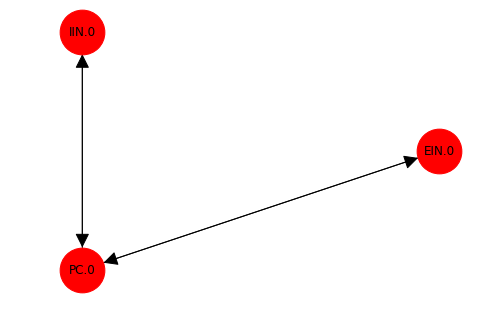

In [17]:
import matplotlib.pyplot as plt
import networkx as nx
pos=nx.spring_layout(circuit.graph)
nx.draw_shell(circuit.graph, with_labels=True, node_size=2000, arrowsize=30)

Alternatively, PyRates provides a custom implementation using `pydot`:

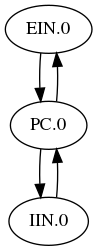

In [18]:
from pyrates.utility.visualization import plot_network_graph
plot_network_graph(circuit)

## Part 3: How do I run simulations on my network model?

The *intermediate representation* is a user-friendly representation of a network model. Computations are realised via a *computation backend*. In the backend, the IR is restructured into what we call the `ComputeGraph`:

In [8]:
T = 10.0
dt = 0.0001
from pyrates.backend import ComputeGraph
net = ComputeGraph(circuit, vectorization="nodes", dt=dt, build_in_place=False)

/home/rgast/PycharmProjects/PyRates/pyrates/backend/backend_wrapper.py:265: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  idx = results['args'].index(arg)


Here, the keyword argument `vectorization` is used to group identical nodes such that their equations can be calculated more efficiently. A such reorganised network consists of 2 instead of 3 nodes, because the EIN and IIN nodes actually contain the same equations:

In [80]:
net.net_config.nodes

NodeView(('IIN_EIN_all.0', 'PC_all.0'))

Simulations are started using the `.run` method of our `ComputeGraph`. Note that we are using a so called *placeholder* variable `u` to pass external input to drive the circuit. The variable `u` is contained in the operator `RPO_e_pc.0` of our `PC` node:

In [9]:
import numpy as np
ext_input = np.random.uniform(120., 320., (int(T/dt), 1))
results = net.run(simulation_time = T, 
                  outputs={'V_PC': ('PC', 'PRO.0', 'PSP'), 
                           'V_EIN': ('EIN', 'PRO.0', 'PSP'), 
                           'V_IIN': ('IIN', 'PRO.0', 'PSP')}, 
                  inputs={('PC', 'RPO_e_pc.0', 'u'): ext_input})

Preparing simulation...
Running simulation...


The `outputs` keyword is used to indicate which state variables to record during the simulation. In this case, we record the variable `PSP` of the operator `PRO.0` on node `PC` and name it `V`. The resulting timeseries are returned as a handy `pandas.DataFrame`:

In [7]:
results.head()

var,V
node,PC
0.0000,0.000000e+00
0.0001,0.000000e+00
0.0002,6.514010e-07
0.0003,1.937114e-06
0.0004,3.842168e-06


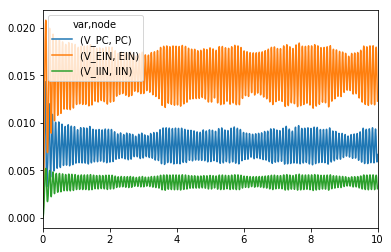

In [11]:
results.plot()

For visualization, processing and analysis of those timeseries, PyRates provides a variety of wrappers to other open-source Python tools such as `seaborn` and `MNE Python`. Some of the available post-processing/visualization methods are used as follows: 

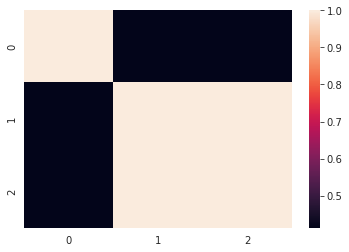

In [12]:
from pyrates.utility import functional_connectivity, plot_connectivity
fc = functional_connectivity(results, metric='corr')
plot_connectivity(fc)

Creating RawArray with float64 data, n_channels=3, n_times=100000
    Range : 0 ... 99999 =      0.000 ...    10.000 secs
Ready.
Effective window size : 0.205 (s)


/home/rgast/PycharmProjects/PyRates/pyrates/utility/mne_wrapper.py:122: RuntimeWarning: 2 channel names are too long, have been truncated to 15 characters:
["('V_EIN', 'EIN')", "('V_IIN', 'IIN')"]
  info = mne.create_info(ch_names=ch_names_str, ch_types=ch_types, sfreq=1/dt)
/home/rgast/PycharmProjects/PyRates/pyrates/utility/visualization.py:515: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


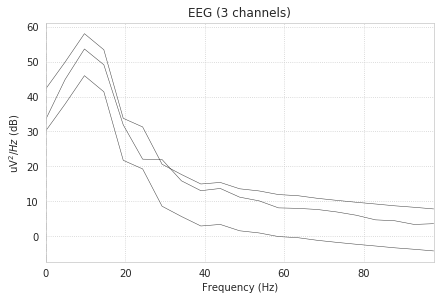

In [13]:
from pyrates.utility import plot_psd
plot_psd(results)

Creating RawArray with float64 data, n_channels=3, n_times=100000
    Range : 0 ... 99999 =      0.000 ...    10.000 secs
Ready.
Setting up band-pass filter from 8 - 10 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 2.5 Hz
Filter length of 16501 samples (1.650 sec) selected
Converting time column to int64...
Converting time column to int64...


/home/rgast/PycharmProjects/PyRates/pyrates/utility/mne_wrapper.py:122: RuntimeWarning: 2 channel names are too long, have been truncated to 15 characters:
["('V_EIN', 'EIN')", "('V_IIN', 'IIN')"]
  info = mne.create_info(ch_names=ch_names_str, ch_types=ch_types, sfreq=1/dt)
/home/rgast/Software/anaconda3/envs/pyrates/lib/python3.6/site-packages/mne-0.17.0-py3.6.egg/mne/io/base.py:1097: ComplexWarning: Casting complex values to real discards the imaginary part
  self._data = self._data.astype(dtype)


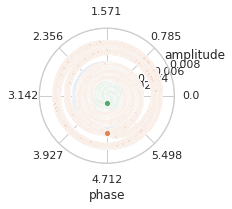

In [15]:
from pyrates.utility import analytic_signal, plot_phase
sig = analytic_signal(results, fmin=8, fmax=10)
plot_phase(sig)

## Part 4: How do I run parameter studies on my model?

PyRates provides functionalities to perform parameter sweeps over high-dimensional model parameter spaces. These functionalities are found in the `utilities` module. They allow to perform multi-dimensional parameter sweeps on single machines using the `grid_search()` function and on compute clusters using the `ClusterGridsearch` class. In the following, we will use `grid_search()` for a simple investigation of how the Jansen-Rit model behavior changes when its connection weights are scaled up or down. 

In [17]:
from pyrates.utility import grid_search

# generate 5 sets of differently scaled connection strengths
C = [68., 128., 135., 270., 675., 1350.]
pc_ein, ein_pc, pc_iin, iin_pc = [], [], [], []
for c in C:
    pc_ein.append(c)
    ein_pc.append(0.8*c)
    pc_iin.append(0.25*c)
    iin_pc.append(0.25*c)

# perform parameter study
results = grid_search("model_templates.jansen_rit.simple_jansenrit.JRC", 
                      param_grid={'PC_EIN': pc_ein, 
                                  'EIN_PC': ein_pc, 
                                  'PC_IIN': pc_iin,
                                  'IIN_PC': iin_pc},
                      param_map={'PC_EIN': {'var': [(None, 'weight')],
                                            'edges': [('PC.0', 'EIN.0', 0)]},
                                 'EIN_PC': {'var': [(None, 'weight')],
                                            'edges': [('EIN.0', 'PC.0', 0)]},
                                 'PC_IIN': {'var': [(None, 'weight')],
                                            'edges': [('PC.0', 'IIN.0', 0)]},
                                 'IIN_PC': {'var': [(None, 'weight')],
                                            'edges': [('IIN.0', 'PC.0', 0)]}},
                     simulation_time=T, dt=dt, permute_grid=False,
                     sampling_step_size=1e-3, 
                     inputs={('PC', 'RPO_e_pc.0', 'u'): ext_input},
                     outputs={'V': ('PC', 'PRO.0', 'PSP')},
                     init_kwargs={'vectorization': 'nodes'})

/home/rgast/PycharmProjects/PyRates/pyrates/backend/backend_wrapper.py:265: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  idx = results['args'].index(arg)


Preparing simulation...
Running simulation...


/home/rgast/PycharmProjects/PyRates/documentation/CNS_2019_Tutorial/pyrates_build/net0/layer_3/op_0.py:5: RuntimeWarning: overflow encountered in exp
  m_out_17[:] = np.divide(c_191,np.add(c_190,np.exp(np.multiply(c_189,np.subtract(c_188,np.sum(np.asarray((PSP_28,PSP_29,)),c_187))))))[:]


For visualization of the time series, we use a wrapper to `seaborn`.

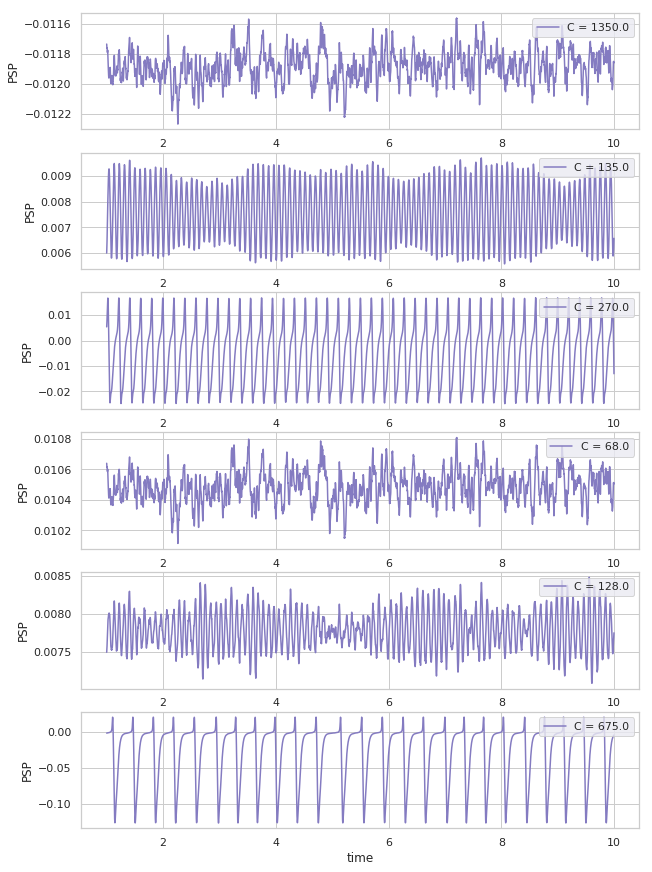

In [18]:
from pyrates.utility import create_cmap, plot_timeseries
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=len(C), figsize=(10, 15))
cmap = create_cmap('pyrates_purple', as_cmap=False, n_colors=1, reverse=True)
for i, ax in enumerate(axes):
    plot_timeseries(results.iloc[results.index > 1.0, i], ax=ax, cmap=cmap, 
                    ylabel='PSP')
    ax.legend([f'C = {results.columns.values[i][0]}'], loc='upper right')